# 🎁🎅**Tarea 3 - Introducción al Deep Learning** 🎅🎁
Integrantes: 
- Michael Clemans
- Paula Marín
- Bárbara Perez
- Sebastián Urbina






# Preparación

## Librerias

Primero se cargan todas las librerias que se usarán para esta pregunta.


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import convolve2d
import tensorflow as tf
from tensorflow import keras
import os
import keras.backend as K
import warnings
warnings.filterwarnings("ignore")

## Conectar drive

Se conecta con un drive para enlazar el contenido que se necesita. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Funciones útiles

Se define la siguiente función que se usará posteriormente para graficar el entrenamiento de los modelos

In [ ]:
def graficos_entreno(metricas, h):
    f, ax = plt.subplots(1,2,figsize=(14,4))
    k = 0
    for i in range(2):
        ax[i].plot(h.history[metricas[k]]);
        ax[i].plot(h.history['val_{}'.format(metricas[k])]);
        ax[i].set_ylabel(metricas[k])
        ax[i].legend(['train', 'val'], loc='upper left')
        ax[i].set_xlabel('epoch')
        k+=1
    plt.show()

Función extraida del auxiliar 9, que servirá posteriormente para graficar la data

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

La siguiente función permite tomar una imagen del conjunto de entrenamiento al azar.

In [ ]:
import random
from random import sample
import matplotlib.image as mpimg
from PIL import Image
random.seed(1)
def img_sample(name, out_shape):
    """
    Toma una imagen al azar del conjunto de entrenamiento(train) de la categoria "name" y dimensiones "out_shape"
    """
    path = 'train/'+name #buscamos la imagen
    list_images = os.listdir(os.path.join(path)) #listamos todas las imagenes
    choice = sample(list_images, 1)[0] #elegimos una al azar
    img = Image.open(path+"/"+choice).resize((out_shape,out_shape)) #la abrimos y cambiamos el tamaño
    return img

La siguiente función grafica la imagen real versus la predicción de 2 modelos. Si la predicción es errónea se busca una imagen al azar de la predicción errónea para observar visualmente alguna idea de por qué se equivocó.

In [ ]:
def plot_prediction(img, label, modelo_sin_aug, modelo_con_aug):
    """
    Recibe una imagen(img) y una etiqueta(label) y 2 modelos. Grafica la imagen real versus las predicciones de los modelos.

    Si el modelo se equivoca buscar una imagen al azar de la predicción errónea.
    """
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(10,6)) #1 fila 3 columnas
    #Real
    real_name = test_labels[label[0].argmax()]
    #Prediction model sin data aug.
    predict_1 = modelo_sin_aug.predict(img).argmax(1)[0] #predecimos con el modelo sin data augmentation
    predicted_name_1 = test_labels[predict_1]
    #Prediction model con data aug.
    predict_2 = modelo_con_aug.predict(img).argmax(1)[0] #predecimos con el modelo con data augmentation 
    predicted_name_2 = test_labels[predict_2]

    #Graficamos la imagen real
    ax1.imshow(img[0])
    ax1.set_title(f'Real: {real_name}')

    if real_name == predicted_name_1: #Si la predicción coincide devolvemos la misma imagen
        ax2.imshow(img[0])
        ax2.set_title(f'Model without Data Aug.\nPredicted: {predicted_name_1}')   
    
    else:
        ax2.imshow(img_sample(predicted_name_1, IMG_SHAPE)) #Si la prediccion es erronea buscamos una imagen de la prediccion(erronea)
        ax2.set_title(f'Model without Data Aug.\nPredicted: {predicted_name_1}') 

    if real_name == predicted_name_2:
        ax3.imshow(img[0])
        ax3.set_title(f'Model with Data Aug.\nPredicted: {predicted_name_2}')   

    else:
        ax3.imshow(img_sample(predicted_name_2, IMG_SHAPE))
        ax3.set_title(f'Model with Data Aug.\nPredicted: {predicted_name_2}') 

La siguiente función grafica la matriz de confusión(se utilizará para la P2) y un resumen de las predicciones.

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report

def plot_cm(X_test, Y_test, model):
    y_true = Y_test
    y_pred = np.where( model.predict(X_test)>0.5, 1,0).reshape(-1)


    fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_true, y_pred),figsize=(8,8), show_absolute=True, show_normed=False, colorbar=False)
    plt.title('Matriz de confusión')
    plt.show()
    print(classification_report(y_true, y_pred))

# Pregunta 1

Se procede a cargar la data. `index` contiene la ruta a cada una de las imágenes y `metadata` información sobre los labels.

In [ ]:
base_path = '/content/drive/MyDrive/Colab Notebooks (1)/Intro al Deep Learning/Tarea_3/data_lego/'
#base_path = '/content/drive/MyDrive/Tarea_3/data_lego/'
index = pd.read_csv(base_path+'index.csv')
index_test = pd.read_csv(base_path+'test.csv')
metadata = pd.read_csv(base_path+'metadata.csv')

El `dataframe` `index` contiene la ruta a cada imagen con su respectivo label.

In [ ]:
index.head(3)

,path,class_id
0,marvel/0001/001.jpg,1
1,marvel/0001/002.jpg,1
2,marvel/0001/003.jpg,1


## Análisis exploratorio

Se muestras algunas imagenes aleatorias del dataset con su respectivo label y nombre

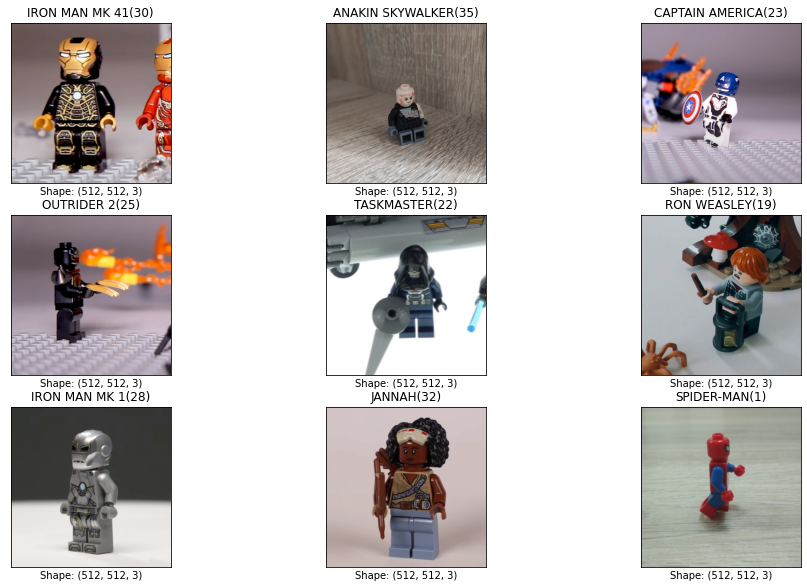

In [ ]:
import matplotlib.image as mpimg

n = 3
fig = plt.figure(figsize=(16,10))
for i, (path, label) in enumerate(index.sample(n**2).values):
    plt.subplot(n,n, i+1) 
    imagen = mpimg.imread(base_path + path)
    plt.xticks([]) #quitamos eje x
    plt.yticks([]) #quitamos eje y
    name = metadata[metadata['class_id']==label]['minifigure_name'].values.item() #Recuperamos el nombre de la figura segun su label
    plt.title(name +'({})'.format(label)) #Agregamos el titulo con el label entre parentesis
    plt.xlabel(f'Shape: {imagen.shape}')
    plt.imshow(imagen)

Se tienen imagenes de 512x512 pixeles con distintos personajes y distintos ángulos de captura.

A continuación se revisa el histograma del total de clases

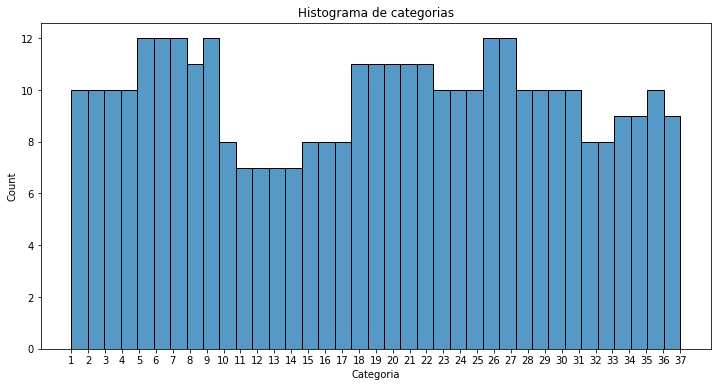

In [ ]:
f, ax = plt.subplots(figsize=(12,6))
sns.histplot(index['class_id'],ax=ax, bins=37)
max_label = max(index['class_id'])
ax.set_xticks(list(range(1,max_label+1)))
plt.title('Histograma de categorias')
plt.xlabel('Categoria');

Se puede observar que hay 37 categorías, que cuentan con una mínima cantidad de ejemplos correspondiente a 7 para algunas y 12 para otras. En general no están tan desbalanceados los datos, sin embargo, en cantidad son pocos.

## Reordenar las imágenes

En esta sección se copiarán las imagenes desde las carpetas base a una llamada `train`, donde se creará una carpeta por categoría(label) y se iran guardando. Esto para poder utilizar posteriormente `ImageDataGenerator` de keras.

In [ ]:
import os
import shutil

try:
    os.mkdir('train') #Creamos una carpeta de train 
    os.mkdir('test')
except:
    print('Ya existe la carpeta train y test')

base_train = '/content/train/'
base_test = '/content/test/'

labels = pd.unique(index['class_id'])
#Copiamos la data en train
for label in labels: 
    class_name = metadata.loc[metadata['class_id']==label, 'minifigure_name'].values[0]
    try:
        os.mkdir(base_train+class_name) #Entramos a "train/" y creamos la carpeta respectiva del label
        os.mkdir(base_test+class_name)  #Entramos a "test/" y creamos la carpeta respectiva del label
    except:
        print(f'Carpeta {class_name} ya existe')
    label_dir_train = os.path.join(base_train, class_name)
    label_dir_test = os.path.join(base_test, class_name)
    for img_path in index[index['class_id']==label]['path']: #Recorremos cada imagen por carpeta
        shutil.copy(base_path + img_path, label_dir_train)
    
    for img_path in index_test[index_test['class_id']==label]['path']: #Recorremos las imagenes de la carpeta test
        shutil.copy(base_path + img_path, label_dir_test)

## Preprocesamiento

Se preprocesan los datos utilizando `ImageDataGenerator` de `Keras`, lo que hace el trabajo mucho más fácil. Asimismo, se crea un conjunto de validación correspondiente al 20% del de entrenamiento.

Cabe destacar que se utilizará `IMG_SHAPE=224` porque es la dimensión de entrada que recibe el modelo de base convolucional `MobileNetV2`.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
IMG_SHAPE = 224

image_gen_train = ImageDataGenerator(rescale= 1./255, validation_split=0.2)


#Train
data_gen_train = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                    directory=base_train, #directorio(/train)
                                    target_size=(IMG_SHAPE,IMG_SHAPE),
                                    shuffle=True,
                                    subset='training',
                                    seed=1)

#Validación
data_gen_val = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                    directory=base_train, #directorio(/train)
                                    target_size=(IMG_SHAPE,IMG_SHAPE),
                                    shuffle=True,
                                    subset='validation',
                                    seed=1)

Found 300 images belonging to 37 classes.
Found 61 images belonging to 37 classes.


Adicionalmente se cargan los datos de testeo para comparar posteriormente ambos modelos

In [ ]:
image_gen_test = ImageDataGenerator(rescale= 1./255)

#Testing
data_gen_test = image_gen_test.flow_from_directory(batch_size=1,
                                    directory=base_test,#directorio(/test)
                                    target_size=(IMG_SHAPE,IMG_SHAPE),
                                    shuffle=False)

Found 76 images belonging to 37 classes.


Imprimir algunas imagenes del generador

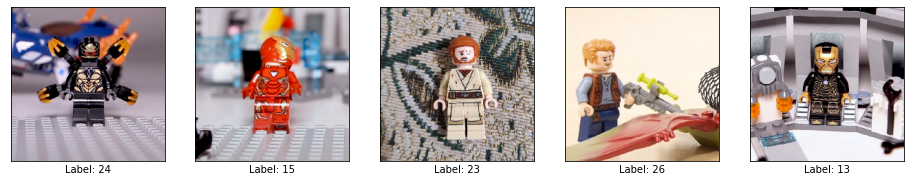

In [ ]:
fig = plt.figure(figsize=(16,10))
for img, label in data_gen_train:
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img[i])
        plt.xlabel(f'Label: {np.argmax(label[i])}')
    break
plt.show()

## Modelo Sin Data augmentation

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Activation

Se utilizará como base del modelo(feature extraction) un modelo pre-entrenado llamado MobileNetV2. Se utilizará sólo como base convolucional, por lo que se reentrenará una nueva cabecera.

In [ ]:
import tensorflow_hub as hub

url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" #descargamos el modelo
mobilenetv2 = hub.KerasLayer(url, input_shape=(IMG_SHAPE,IMG_SHAPE,3)) #lo guardamos

In [ ]:
#Congelamos el modelo descargado
mobilenetv2.trainable = False

Se le agrega una capa densa de 512 neuronas y DropOut de 0.5. Asimismo en la salida se tiene una softmax sobre 37(cantidad clases) neuronas.

In [ ]:
import keras.backend as K
K.clear_session()

drop_out = 0.5
n_classes = data_gen_train.num_classes

modelo_sin_aug = Sequential([
                             mobilenetv2, #Red preentrenada
                             Dense(256, activation='relu'), #Fully connected de 512 neuronas
                             Dropout(drop_out),
                             Dense(256, activation='relu'), #Fully connected de 512 neuronas
                             Dropout(drop_out),
                             Dense(n_classes, activation='softmax')
])
modelo_sin_aug.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_17 (Dense)            (None, 256)               327936    
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 256)               65792     
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 37)                9509      
                                                                 
Total params: 2,661,221
Trainable params: 403,237
Non-

Se utilizará la métrica de Accuracy para evaluar los mdoelos

In [ ]:
modelo_sin_aug.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

Se procede a entregar agregando la callback de `checkpoint`, la cuál guardará el modelo con mejor `val_accuracy` durante el entrenamiento.

In [ ]:
N_EPOCHS = 100
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=12,
                                               verbose=1)
checkpoint = keras.callbacks.ModelCheckpoint(filepath="best_modelo_sin_aug", 
                                             save_weights_only=True,
                                             monitor='val_accuracy', 
                                             mode='max', 
                                             save_best_only=True, 
                                             verbose=1)

history_modelo_sin_aug = modelo_sin_aug.fit(
    data_gen_train,
    steps_per_epoch=int(np.ceil(data_gen_train.samples // BATCH_SIZE)),
    epochs=N_EPOCHS,
    validation_data=data_gen_val,
    validation_steps=int(np.ceil(data_gen_val.samples // BATCH_SIZE)),
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 4.0476 - accuracy: 0.0224
Epoch 00001: val_accuracy improved from -inf to 0.03125, saving model to best_modelo_sin_aug
9/9 [==============================] - 5s 360ms/step - loss: 4.0476 - accuracy: 0.0224 - val_loss: 3.5677 - val_accuracy: 0.0312
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 3.6170 - accuracy: 0.0625
Epoch 00002: val_accuracy improved from 0.03125 to 0.06250, saving model to best_modelo_sin_aug
9/9 [==============================] - 2s 270ms/step - loss: 3.6170 - accuracy: 0.0625 - val_loss: 3.3688 - val_accuracy: 0.0625
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 3.4191 - accuracy: 0.1381
Epoch 00003: val_accuracy did not improve from 0.06250
9/9 [==============================] - 2s 234ms/step - loss: 3.4191 - accuracy: 0.1381 - val_loss: 3.4221 - val_accuracy: 0.0625
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 3.2616 - accuracy: 0.11

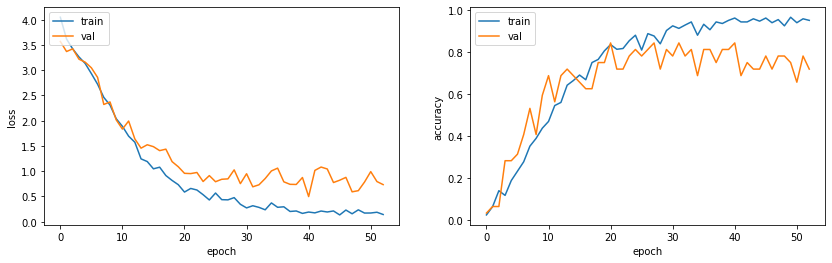

In [ ]:
graficos_entreno( ['loss', 'accuracy'], history_modelo_sin_aug)

En los gráficos se observa un gap no tan grande, y se observa que el modelo aprende bastante en las primeras 20 epocas, donde el accuracy de validación aumenta. Luego de esto, comienza de alguna manera a overfittear y a aumentar el gap entre train y val.


Se cargan los pesos del mejor modelo guardado en base al `val_accuracy`

In [ ]:
modelo_sin_aug.load_weights('best_modelo_sin_aug')

## Modelo con Data Augmentation

Se generan nuevas imágenes, las cuales corresponden a modificaciones de las imágenes de entrenamiento de cada personaje, donde se aplica rotación, zoom y reflexión, para luego agregarlas al modelo y aumentar la cantidad de datos.

In [ ]:
BATCH_SIZE = 32
IMG_SHAPE = 224

image_gen_train_aug = ImageDataGenerator(rescale= 1./255,
                                     rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=5,
                                     zoom_range=0.2,
                                     validation_split=0.2)

image_gen_val_aug = ImageDataGenerator(rescale= 1./255,
                                       validation_split=0.2)
#Train
data_gen_train_aug = image_gen_train_aug.flow_from_directory(batch_size=BATCH_SIZE,
                                    directory=base_train,
                                    target_size=(IMG_SHAPE,IMG_SHAPE),
                                    subset='training',
                                    seed=1)

#Validation
data_gen_val_aug = image_gen_val_aug.flow_from_directory(batch_size=BATCH_SIZE,
                                    directory=base_train,
                                    target_size=(IMG_SHAPE,IMG_SHAPE),
                                    subset='validation',
                                    seed=1)

Found 300 images belonging to 37 classes.
Found 61 images belonging to 37 classes.


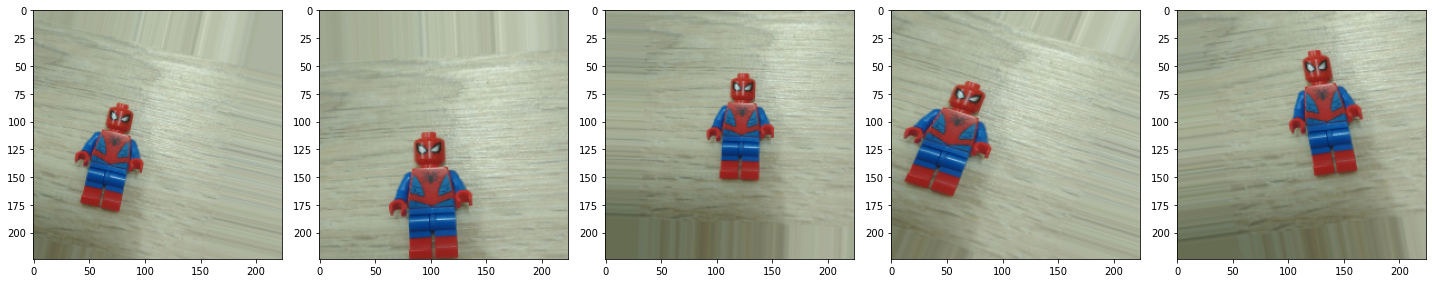

In [ ]:
augmented_images = [data_gen_train_aug[6][0][0] for i in range(5)] #[class][img,label][batch_size]
plotImages(augmented_images)

In [ ]:
drop_out = 0.5
n_classes = data_gen_train.num_classes

modelo_con_aug = Sequential([
                             mobilenetv2, #Red preentrenada
                             Dense(256, activation='relu'),
                             Dropout(drop_out),
                             Dense(256, activation='relu'),
                             Dropout(drop_out),
                             Dense(n_classes, activation='softmax')
])
modelo_con_aug.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_14 (Dense)            (None, 256)               327936    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 256)               65792     
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 37)                9509      
                                                                 
Total params: 2,661,221
Trainable params: 403,237
Non-

In [ ]:
modelo_con_aug.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
N_EPOCHS = 100
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=12,
                                               verbose=1)
checkpoint = keras.callbacks.ModelCheckpoint(filepath="best_modelo_con_aug", 
                                             save_weights_only=True,
                                             monitor='val_accuracy', 
                                             mode='max', 
                                             save_best_only=True, 
                                             verbose=1)
history_modelo_con_aug = modelo_con_aug.fit(
    data_gen_train_aug,
    steps_per_epoch=int(np.ceil(data_gen_train_aug.samples // BATCH_SIZE)),
    epochs=N_EPOCHS,
    validation_data=data_gen_val_aug,
    validation_steps=int(np.ceil(data_gen_val_aug.samples // BATCH_SIZE)),
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 4.2255 - accuracy: 0.0224
Epoch 00001: val_accuracy improved from -inf to 0.03125, saving model to best_modelo_con_aug
9/9 [==============================] - 8s 691ms/step - loss: 4.2255 - accuracy: 0.0224 - val_loss: 3.6301 - val_accuracy: 0.0312
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 3.6991 - accuracy: 0.0410
Epoch 00002: val_accuracy improved from 0.03125 to 0.09375, saving model to best_modelo_con_aug
9/9 [==============================] - 5s 591ms/step - loss: 3.6991 - accuracy: 0.0410 - val_loss: 3.4042 - val_accuracy: 0.0938
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 3.4908 - accuracy: 0.0858
Epoch 00003: val_accuracy improved from 0.09375 to 0.18750, saving model to best_modelo_con_aug
9/9 [==============================] - 5s 583ms/step - loss: 3.4908 - accuracy: 0.0858 - val_loss: 3.3839 - val_accuracy: 0.1875
Epoch 4/100
9/9 [==============================] 

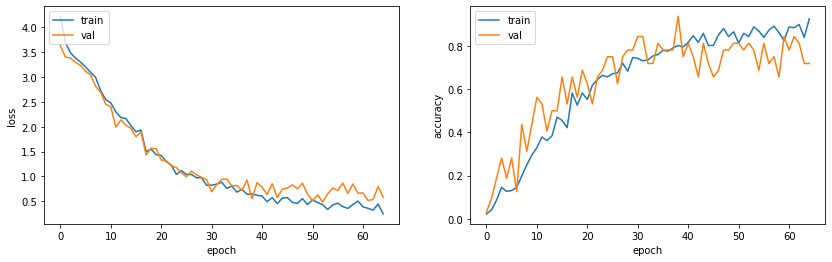

In [ ]:
graficos_entreno( ['loss', 'accuracy'], history_modelo_con_aug)

En ambos gráficos, correspondientes al de loss y al de accuracy se observa que el gap no es tan grande entre los datos de entrenamiento y datos de validación.
En el gráfico de loss se observa que hay una mayor perdida en los datos de validación, pero no es tan distante a la de entrenamiento. 
En el gráfico de accuracy, se observa que los datos de validación presenta una menor exactitud, aún así se acerca a un 80% lo cual no es malo.

Se cargan los pesos del mejor modelo guardado en base al `val_auc`

In [ ]:
modelo_con_aug.load_weights('best_modelo_con_aug')

## Comparación modelos

In [ ]:
print('Accuracy modelo sin data augmentation: {:.2f}%'.format(100*modelo_sin_aug.evaluate(data_gen_test)[1]))

76/76 [==============================] - 1s 15ms/step - loss: 1.1584 - accuracy: 0.7500
Accuracy modelo sin data augmentation: 75.00%


In [ ]:
print('Accuracy modelo con data augmentation: {:.2f}%'.format(100*modelo_con_aug.evaluate(data_gen_test)[1]))

76/76 [==============================] - 1s 15ms/step - loss: 0.7266 - accuracy: 0.8553
Accuracy modelo con data augmentation: 85.53%


### Predicciones

Se define `test_labels` que no es nada mas que el diccionario de las clases "invertido" para poder acceder a cada nombre del personaje de lego directamente con el numero asociado.

In [ ]:
test_labels = {v: k for k,v in data_gen_test.class_indices.items()} 
test_labels

{0: 'ANAKIN SKYWALKER',
 1: 'AUNT MAY',
 2: 'BLACK WIDOW',
 3: 'CAPTAIN AMERICA',
 4: 'CARA DUNE',
 5: 'DARTH VADER',
 6: 'EMPEROR PALPATINE',
 7: 'FIREFIGHTER',
 8: 'GENERAL GRIEVOUS',
 9: 'GHOST SPIDER',
 10: 'HAN SOLO',
 11: 'HARRY POTTER',
 12: 'IRON MAN MK 1',
 13: 'IRON MAN MK 41',
 14: 'IRON MAN MK 5',
 15: 'IRON MAN MK 50',
 16: 'JANNAH',
 17: 'KLATOOINIAN RAIDER 1',
 18: 'KLATOOINIAN RAIDER 2',
 19: 'KYLO REN',
 20: 'LUKE SKYWALKER',
 21: 'MACE WINDU',
 22: 'MYSTERIO',
 23: 'OBI-WAN KENOBI',
 24: 'OUTRIDER 1',
 25: 'OUTRIDER 2',
 26: 'OWEN GRADY',
 27: 'R2-D2',
 28: 'RON WEASLEY',
 29: 'SPIDER-MAN',
 30: 'SPIDER-MAN2',
 31: 'TASKMASTER',
 32: 'THE MANDALORIAN',
 33: 'TRACKER TRAQUEUR RASTREADOR',
 34: 'VENOM',
 35: 'YELENA BELOVA',
 36: 'YODA'}

A continuación se observan algunas predicciones de los modelos entrenados. Esta usa la función `plot_prediction` definida en el apartado de funciones a utilizar.

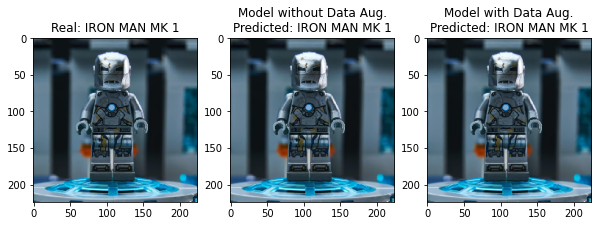

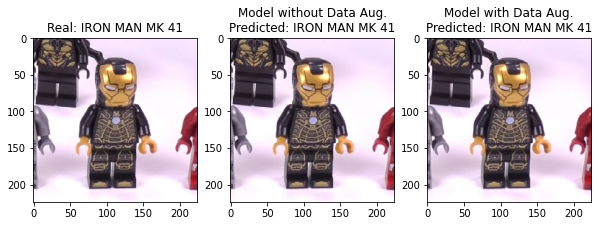

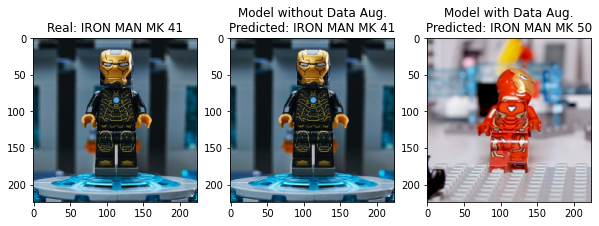

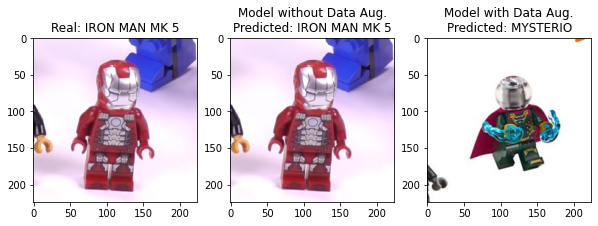

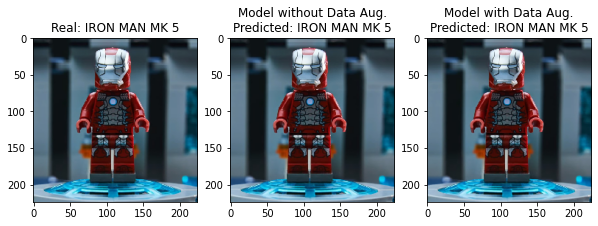

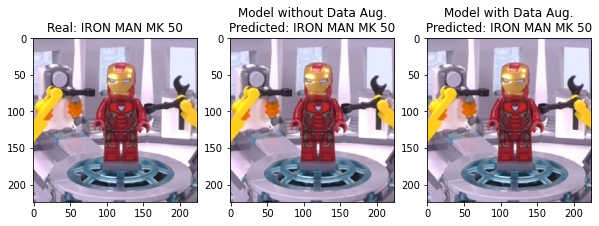

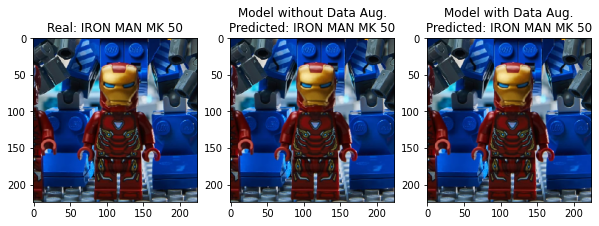

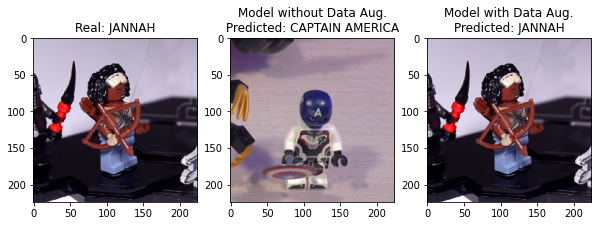

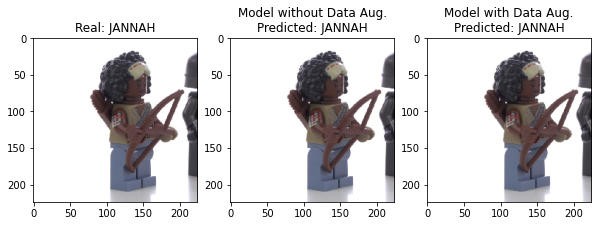

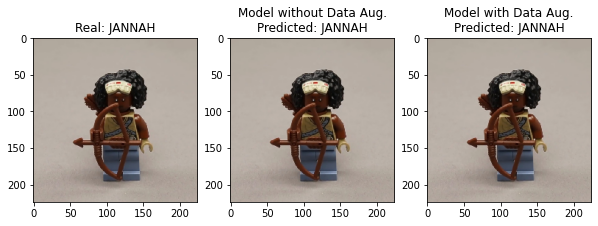

In [ ]:
N = 10 #Predicciones a comprar

i = 0
for img, label in data_gen_test:
    plot_prediction(img, label, modelo_sin_aug, modelo_con_aug)
    i+=1
    if i==N:
        break

Se puede observar que en ciertos casos particulares se equivoca en la predicción, posiblemente porque tienen bastantes colores en común y el modelo no identifica completamente la figura.

## Conclusiones

El dataset trabajado en general tenía pocos datos y una gran cantidad de clases(37), sin embargo, estaban relativamente balanceadas. Es así, como luego de trabajar la data, observar las imágenes y dividirla en train, validacion y testeo usando la función ImageDataGenerator de Keras, se procedió a probar diferentes modelos.

Luego de entrenar a modo de prueba y error muchos modelos de diferentes arquitecturas(que para efectos prácticos no se explicitaron a lo largo del código) y no obtener resultados favorables(no se pasaba el 40% de accuracy en validación) se decidió usar un modelo pre-entrenado como base convolucional congelada. El cual corresponde a MobileNetV2 y posee más de 2M de parámetros. 

Se realizaron varias pruebas entre con/sin data augmentation aplicando estos últimos modelos, en primera instancia se probó sólo con una capa oculta de 512 neuronas, donde el modelo que arrojaba mejores resultados correspondía al sin data augmentation, lo cual era contraintuitivo en primera instancia porque al entregar datos con algunas modificaciones, a priori el modelo debería ser más robusto, sin embargo, se cree que al usar data augmentation y tener sólo una capa oculta de cierta manera el modelo se complejizaba y no alcanzaba a capturar toda la "nueva" información de las imágenes modificadas en la única capa. 

Ante lo anterior, se decidió agregar una capa oculta y probar distintas combinaciones de neuronas(128,256,512) y se llegó a que con 256 el modelo con data augmentation obtenia mejores resultados, llegando inclusó al 85.5% de accuracy en el conjunto de testeo.

Cabe destacar que el aplicar transfer-learning es súper util para situaciones con pocos datos, y especialmente para este situación, donde se tenían muchas clases. 
<!-- Si bien el modelo sin data augmentation tiene mayor exactitud, se observa en el gráfico que se produce un overfitting. En cambio, en el modelo con data augmentation, el cual es menos exacto, se acercan mayormente los valores de entrenamiento y validación, permitiendo que en realidad haya un aprendizaje profundo en vez de aprender de memoria los datos. -->

# Pregunta 2

## Cargar data

In [ ]:
!pip3 install pickle5

     |████████████████████████████████| 256 kB 12.3 MB/s 


Se procede a cargar la data directamente desde el archivo entregado.

In [ ]:
import pickle5 as pickle

path = '/content/drive/MyDrive/Colab Notebooks (1)/Intro al Deep Learning/Tarea_3/dataVentanasEtiquetadas_500ms_v2.pickle'

with open(path, "rb") as fh:
  data = pickle.load(fh)

In [ ]:
# import pickle
# path = '/content/drive/MyDrive/Colab Notebooks (1)/Intro al Deep Learning/Tarea_3/dataVentanasEtiquetadas_500ms_v2.pickle'

# data = pd.read_pickle(path)

In [ ]:
print('Cantidad de instancias:', len(data))

Cantidad de instancias: 4198


Se tienen 4198 instancias, es decir, ventanas temporales que contienen diferentes datos como por ejemplo encefalograma(ecg) y frecuencia cardiaca(hr).

A continuación se observa una de las 4198 instancias y todos los datos que contiene.

In [ ]:
data.get(1)

{'ecg': {'data': array([ 0.79731814,  0.8750984 ,  0.8725225 ,  0.7734293 ,  0.65310634,
          0.63041254,  0.75888084,  0.95331282,  1.03617714,  0.88591203,
          0.56190101,  0.27659635,  0.21116671,  0.32576134,  0.35287607,
          0.02150079, -0.65346061, -1.27814707, -1.31538762, -0.50783791,
          0.84118762,  1.98518177,  2.20591657,  1.30506182, -0.25340064,
         -1.66041178, -2.30007077, -2.11170105, -1.53248625, -1.10860931,
         -1.09977344, -1.36583005, -1.56994678, -1.48548625, -1.14902889,
         -0.76801772, -0.5061027 , -0.34941198, -0.15690012,  0.17494032,
          0.59222739,  0.9096849 ,  0.95231418,  0.67974596,  0.22048659,
         -0.24114539, -0.54178319, -0.66595152, -0.62204315, -0.55039149,
         -0.35108896]),
  'time': array([1.47254758e+12, 1.47254758e+12, 1.47254758e+12, 1.47254758e+12,
         1.47254758e+12, 1.47254758e+12, 1.47254758e+12, 1.47254758e+12,
         1.47254758e+12, 1.47254758e+12, 1.47254758e+12, 1.47254758

Si seleccionamos la data del encefalograma(ecg).

In [ ]:
print('Time-steps: ',len(data.get(1)['ecg']['data'])) #Ejemplo de datos de encefalograma
print(data.get(1)['ecg']['data'])

Time-steps:  51
[ 0.79731814  0.8750984   0.8725225   0.7734293   0.65310634  0.63041254
  0.75888084  0.95331282  1.03617714  0.88591203  0.56190101  0.27659635
  0.21116671  0.32576134  0.35287607  0.02150079 -0.65346061 -1.27814707
 -1.31538762 -0.50783791  0.84118762  1.98518177  2.20591657  1.30506182
 -0.25340064 -1.66041178 -2.30007077 -2.11170105 -1.53248625 -1.10860931
 -1.09977344 -1.36583005 -1.56994678 -1.48548625 -1.14902889 -0.76801772
 -0.5061027  -0.34941198 -0.15690012  0.17494032  0.59222739  0.9096849
  0.95231418  0.67974596  0.22048659 -0.24114539 -0.54178319 -0.66595152
 -0.62204315 -0.55039149 -0.35108896]


Se puede notar que las ventanas temporales tienen 51 valores. Osea, las secuencias son de 51 valores temporales. Lo que conincide con los explicado en el enunciado, pues, la frecuencia de medición es de 100[Hz] y se tienen ventanas de 500[ms].

Por cada paciente se tienen 51 secuencias de tiempo para cada uno de los 20 atributos

## Análisis exploratorio

In [ ]:
def plot_ventana(i):
    """ 
    Permite graficar la data de la i-ésima instancias(de las 4198)
    """
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,8));
    ax1.plot(data.get(i)['ecg']['data'], label='ecg') #se extrae la data de ecg
    ax1.plot(data.get(i)['eda']['data'], label='eda') #se extrae la data de eda
    ax1.plot(data.get(i)['eda']['phasic'], label='phasic') #se extrae la data de phasicc
    ax1.plot(data.get(i)['hr']['data'], label='hr') #se extrae la data de hr
    ax1.plot(data.get(i)['ppg']['data'], label='ppg') #se extrae la data de ppg
    ax1.plot(data.get(i)['skt']['data'], label='skt') #se extrae la data de skt
    ax1.legend()
    ax1.set_xlabel('Tiempo[ms]')
    for k in range(1,15):
        ax2.plot(data.get(i)['eeg'][f'ch{k}'], label=f'ch{k}') #se extrae la data de las 14 señales electroencefalográficas
    ax2.set_title('Señales electroencefalográficas')
    ax2.set_xlabel('Tiempo[ms]')
    ax2.legend()
    fig.suptitle('Label: {}'.format(data.get(i)['label_2']), fontsize=16)
    fig.tight_layout()
    fig.show()

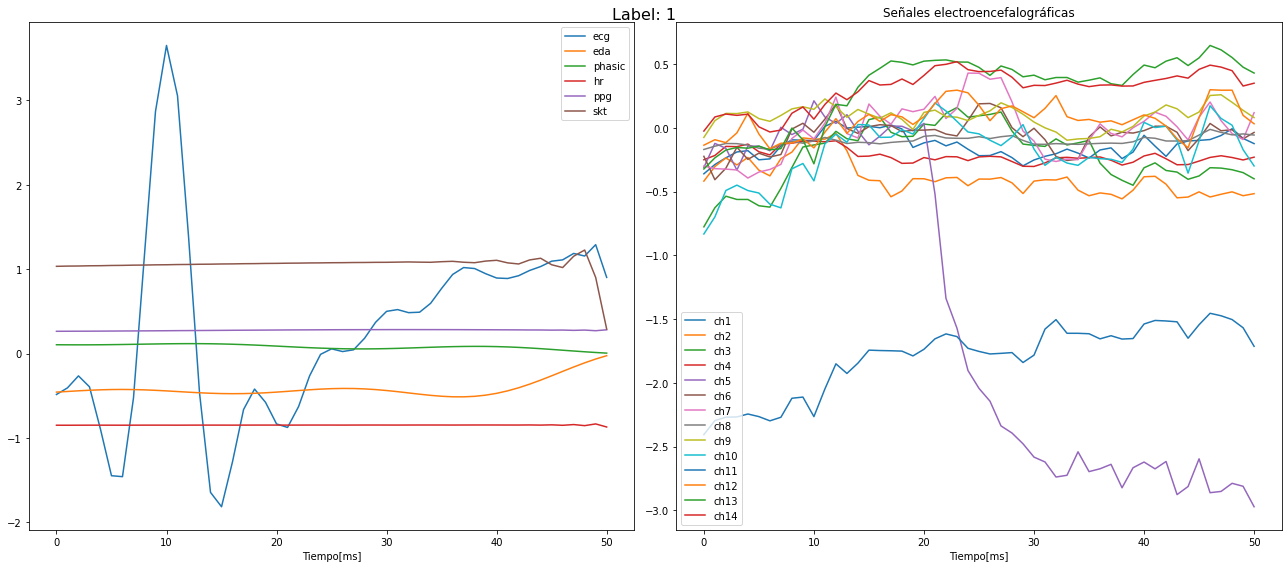

In [ ]:
plot_ventana(500) #Una ventana particular

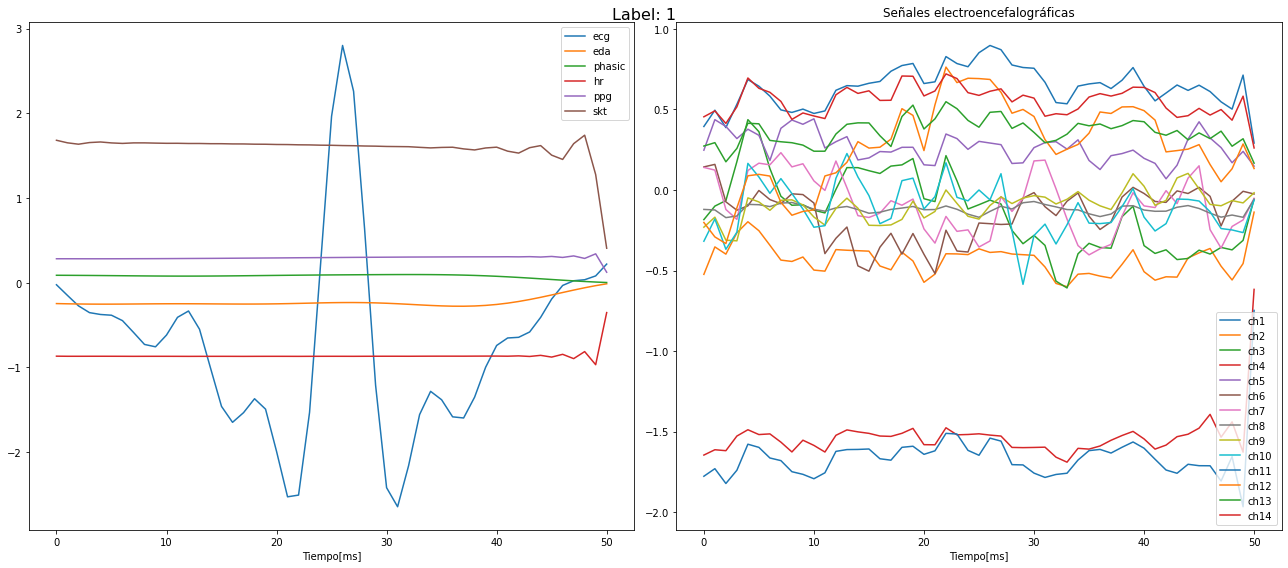

In [ ]:
plot_ventana(600) #ejemplo

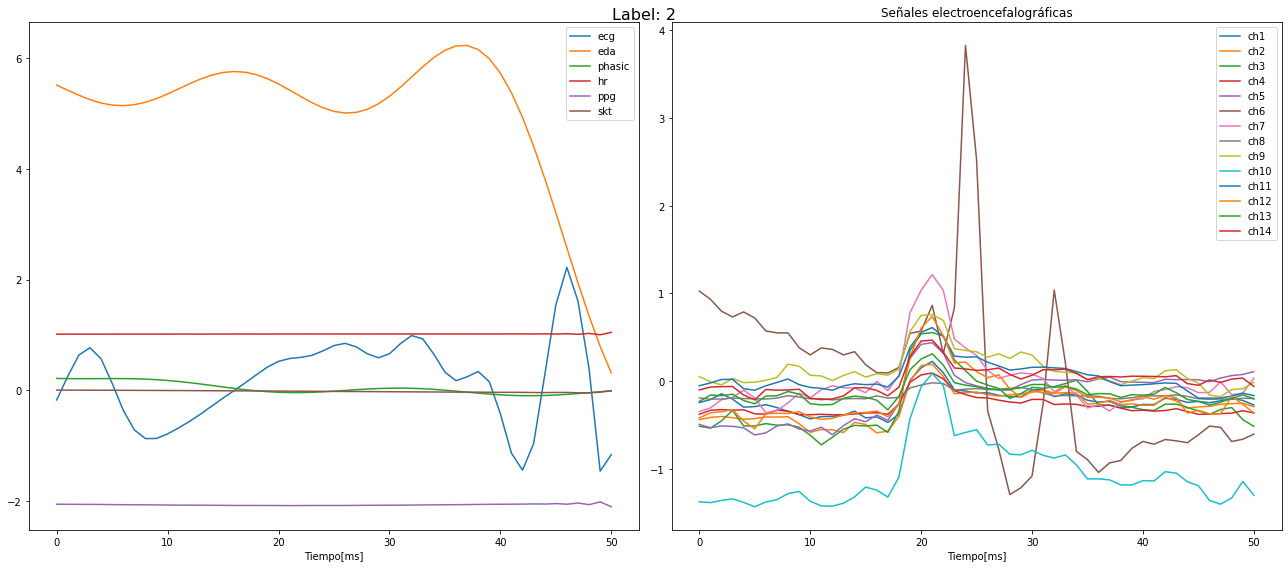

In [ ]:
plot_ventana(20) #otro ejemplo

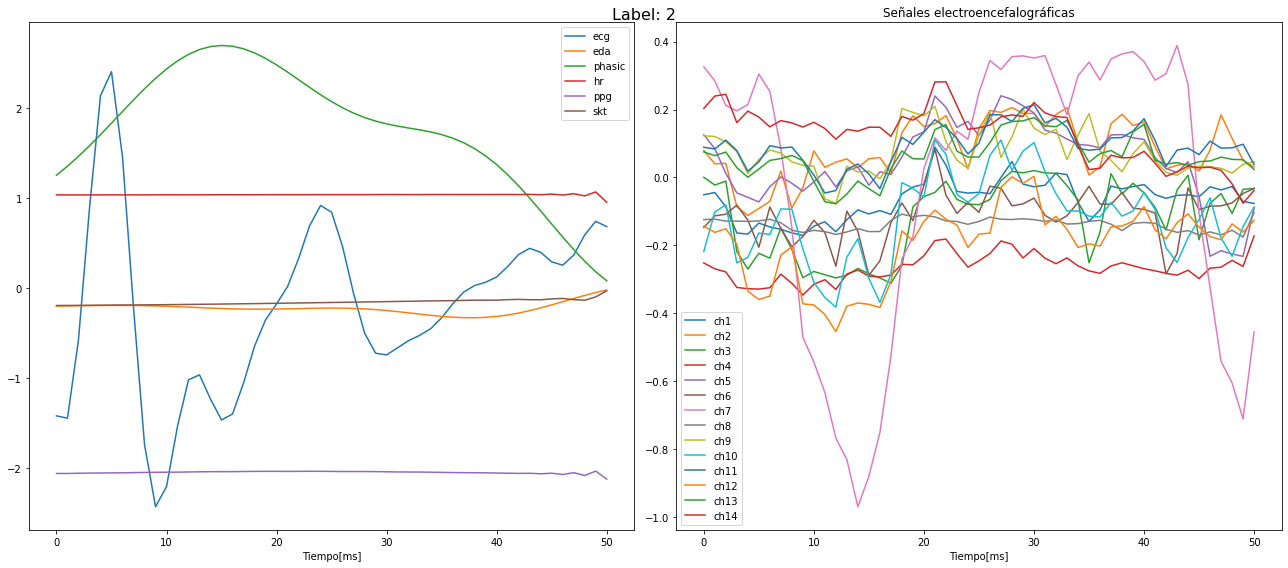

In [ ]:
plot_ventana(26) #otro ejemplo

Graficamente no se observan "patrones" que permitan diferenciar entre ambas clases, ya que en unos casos algunas señales permanecen estáticas a lo largo del tiempo y otras sufren variaciones y viceversa.

Se crea una función que permite extraer toda la data de cierto atributo(att) y retorna una lista con los valores.

In [ ]:
def extraer_att(att):
    """
    Extrae todos los datos de todas las ventanas de cierto atributo
    """
    aux = []
    for ventana in range(len(data)):
        for time_step in data.get(ventana)[att]['data']:
            aux.append(time_step) #Guardamos el time-step
    return aux

Se observará como distribuyen los datos del encefalograma para todas las instancias temporales.

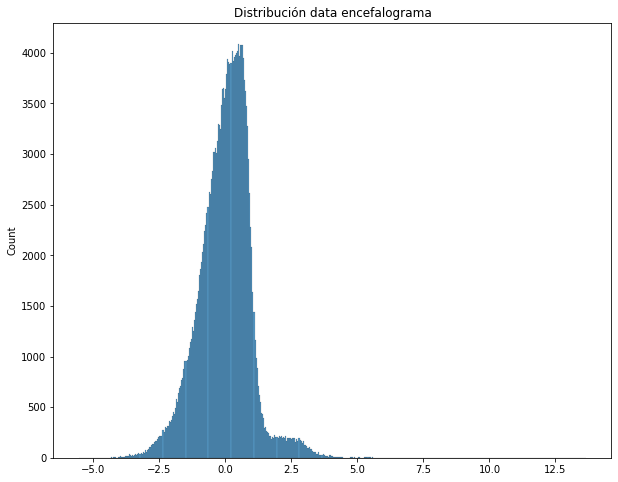

In [ ]:
ecg = extraer_att('ecg')
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(ecg, ax=ax);
ax.set_title('Distribución data encefalograma')
fig.show()

Se puede notar que tiende a distribuir normal la medición del encefalograma para todas las ventanas temporales.

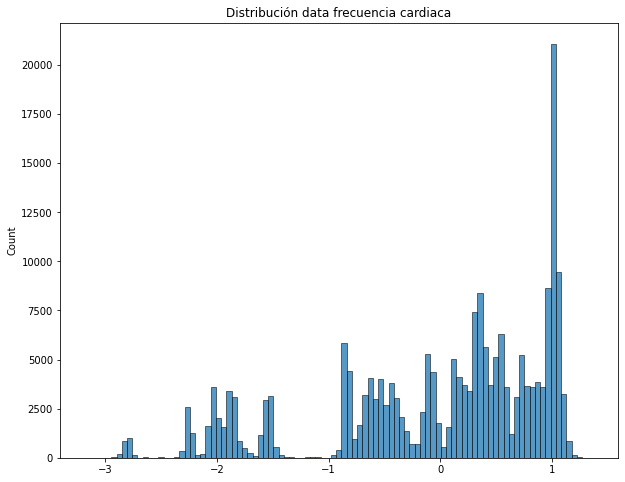

In [ ]:
hr = extraer_att('hr') #extraemos data frecuencia cardiaca
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(hr, ax=ax);
ax.set_title('Distribución data frecuencia cardiaca')
fig.show()

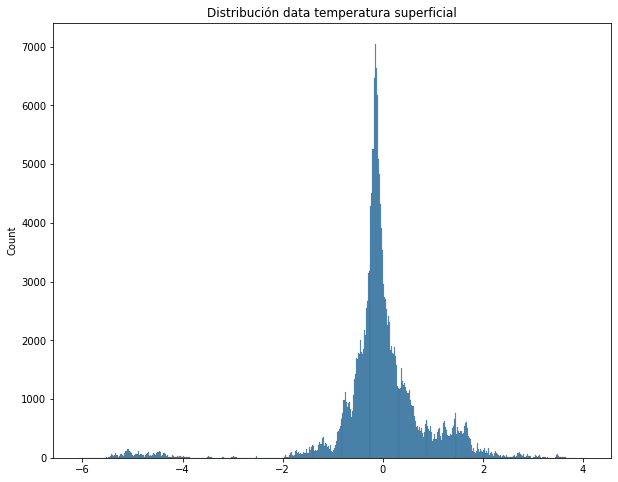

In [ ]:
skt = extraer_att('skt') #extraemos data temperatura superficial
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(skt, ax=ax);
ax.set_title('Distribución data temperatura superficial')
fig.show()

En general las distribuciones tienen a distribuir normal, a excepción de la data de frecuencia cardiaca, la cual no tiene distribución clara.


## Preprocesamiento

Extraeremos la data del diccionario. Por lo que se recorrerán todas las ventanas y se extraerá la información necesaria para dejar los datos en el formato y dimensiones necesarias para entrenar la red.

In [ ]:
atrs = ['ecg','eda','hr','ppg','skt','eeg'] #atributos

X=[]
for j in range(len(data)):
    aux = []
    data_aux = data.get(j)
    for i, att in enumerate(atrs):
        if att=='eda': #Eda contiene data y phasic, por lo que rescatamos ambos valores
            aux.append(data_aux[att]['data'])
            aux.append(data_aux[att]['phasic'])
        elif att=='eeg': #Eeg contiene 14 canales, por lo que, los recorremos y extraemos la data
            for k in range(1,15):
                aux.append(data_aux[att][f'ch{k}'])
        else: 
           aux.append(data_aux[att]['data']) #Del resto se extrae la data
    X.append(aux)
X = np.array(X)

Se observan las dimensiones

In [ ]:
X.shape

(4198, 20, 51)

Se tienen 4198 ventanas con 20 features o características cada una y 51 pasos temporales. Sin embargo, Se requiere la data en dimensiones (samples, time-steps, features). Por lo que se debe intercambiar la dimension (1)(features) por (2)(time-steps)

In [ ]:
X = np.swapaxes(X,1,2) #Cambiamos la dimension 1 por la 2.
print(X.shape)

(4198, 51, 20)


Se crea el vector con los labels o el valor a predecir. Se extraen directamente desde la data. Se usará el `label_2`, por lo que se tratará como un problema de 2 clases.

In [ ]:
from tensorflow.keras.utils import to_categorical

Y = []
for i in range(len(data)): #0,...,4197
    Y.append(data.get(i)['label_2']-1) #Restamos 1 para que todos comiencen desde 0
Y = np.array(Y)
#Y = to_categorical(y) #Lo pasamos a forma vectorial para operarlo en la red

Si se observa la distribución de la variable a predecir

In [ ]:
from collections import Counter
Counter(Y)

Counter({0: 2574, 1: 1624})

Finalmente la data tiene las siguientes dimensiones, tal como se requieren para entrenar una red recurrente.

In [ ]:
print(X.shape)
print(Y.shape)

(4198, 51, 20)
(4198,)


## División en train, valid, test

Se procede a dividir la data en 70% train, 20% validación y 10% para testear finalmente.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.3, random_state=2) # 70% train, 30% val

X_val, X_test, Y_val, Y_test = train_test_split(X_val,Y_val, test_size=0.33, random_state=2) #Del 30% de val restante, queda 20% val y 10% test.

print('Train shape:',X_train.shape, Y_train.shape, '\t || % total: {:.2f}%'.format(100.*X_train.shape[0]/X.shape[0]))
print('Validation shape:',X_val.shape, Y_val.shape, '|| % total: {:.2f}%'.format(100.*X_val.shape[0]/X.shape[0]))
print('Test shape:',X_test.shape, Y_test.shape, '\t || % total: {:.2f}%'.format(100.*X_test.shape[0]/X.shape[0]))

Train shape: (2938, 51, 20) (2938,) 	 || % total: 69.99%
Validation shape: (844, 51, 20) (844,) || % total: 20.10%
Test shape: (416, 51, 20) (416,) 	 || % total: 9.91%


##  Modelo 1. LSTM

In [ ]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, LSTM, CuDNNLSTM, Dropout, BatchNormalization, SimpleRNN, Conv1D, MaxPooling1D, Input

K.clear_session()

n_timesteps, n_features = X_train.shape[1], X_train.shape[2] #Dimensiones (51,20)
input_shape = (n_timesteps, n_features)

drop_out = 0.5
#Creamos el modelo
simple_lstm = Sequential([
                          Input(shape=input_shape),

                          CuDNNLSTM(128),
                          BatchNormalization(),

                          Dense(128, activation='relu'),
                          Dropout(drop_out),
                          Dense(1, activation='sigmoid')                 
])

simple_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm (CuDNNLSTM)      (None, 128)               76800     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 93,953
Trainable params: 93,697
Non-trainable params: 256
__________________________________________________

In [ ]:
simple_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)
history_simple_lstm = simple_lstm.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_val,Y_val), callbacks=[early_stopping])

Epoch 1/100
46/46 [==============================] - 3s 27ms/step - loss: 0.7266 - accuracy: 0.5848 - val_loss: 0.6540 - val_accuracy: 0.6528
Epoch 2/100
46/46 [==============================] - 1s 19ms/step - loss: 0.6685 - accuracy: 0.6195 - val_loss: 0.6469 - val_accuracy: 0.6351
Epoch 3/100
46/46 [==============================] - 1s 21ms/step - loss: 0.6426 - accuracy: 0.6246 - val_loss: 0.6405 - val_accuracy: 0.6540
Epoch 4/100
46/46 [==============================] - 1s 21ms/step - loss: 0.6169 - accuracy: 0.6596 - val_loss: 0.6235 - val_accuracy: 0.6540
Epoch 5/100
46/46 [==============================] - 1s 19ms/step - loss: 0.6099 - accuracy: 0.6675 - val_loss: 0.6165 - val_accuracy: 0.6647
Epoch 6/100
46/46 [==============================] - 1s 19ms/step - loss: 0.6012 - accuracy: 0.6715 - val_loss: 0.6076 - val_accuracy: 0.6588
Epoch 7/100
46/46 [==============================] - 1s 19ms/step - loss: 0.5822 - accuracy: 0.6824 - val_loss: 0.6110 - val_accuracy: 0.6647
Epoch 

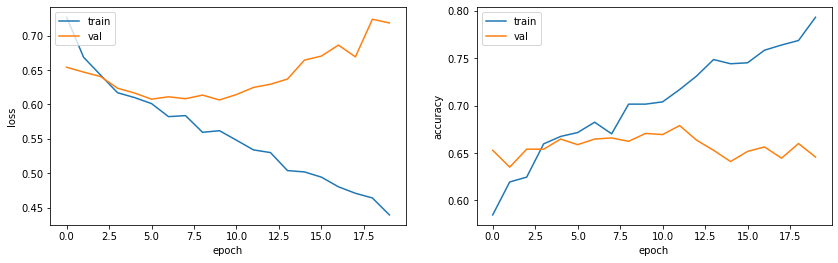

In [ ]:
graficos_entreno( ['loss', 'accuracy'], history_simple_lstm)

Se puede observar un overfitting evidente, pues, el loss de validación desde la epoca 7 comienza a aumentar.

#### Evaluación sobre el conjunto de test.

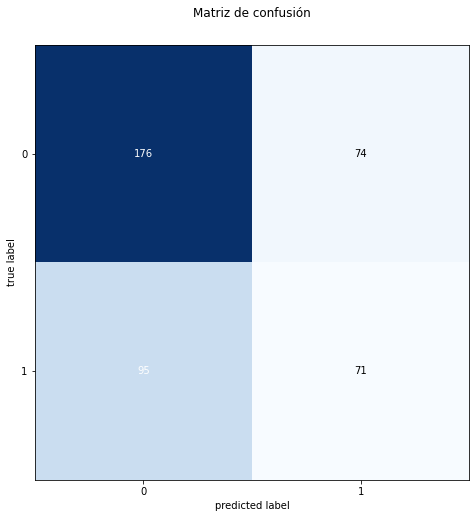

              precision    recall  f1-score   support

           0       0.65      0.70      0.68       250
           1       0.49      0.43      0.46       166

    accuracy                           0.59       416
   macro avg       0.57      0.57      0.57       416
weighted avg       0.59      0.59      0.59       416



In [ ]:
plot_cm(X_test, Y_test, simple_lstm)

Se tiene un accuracy de 59% en el conjunto test.

## Modelo 2. CNN + Stack of LSTM 

Ahora hará un stack de 2 LSTM y se agregará una `capa convolucional` de 32 filtros, para filtrar las series de tiempo y un`max pooling` de tamaño 2. Además, como medida de evitar overfitting se utilizará `BatchNormalization` en las capas intermedias y `DroPout` entre la capa densa de 128 neuronas y la de salida.

In [ ]:
#K.clear_session()

n_timesteps, n_features = X_train.shape[1], X_train.shape[2] #Dimensiones (51,20)
input_shape = (n_timesteps, n_features)
drop_out = 0.5

#Creamos el modelo
cnn_lstm = Sequential([
                          Input(shape=input_shape),

                          Conv1D(filters=64, kernel_size=5, strides=1, activation='relu', padding='same'),
                          MaxPooling1D(pool_size=2),

                          CuDNNLSTM(64, return_sequences=True),
                          BatchNormalization(),

                          CuDNNLSTM(64),
                          BatchNormalization(),     
                          
                          Dense(128, activation='relu'),
                          Dropout(drop_out),
                          Dense(1, activation='sigmoid')     
])
cnn_lstm.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 51, 64)            6464      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 25, 64)           0         
 1D)                                                             
                                                                 
 cu_dnnlstm_13 (CuDNNLSTM)   (None, 25, 64)            33280     
                                                                 
 batch_normalization_13 (Bat  (None, 25, 64)           256       
 chNormalization)                                                
                                                                 
 cu_dnnlstm_14 (CuDNNLSTM)   (None, 64)                33280     
                                                                 
 batch_normalization_14 (Bat  (None, 64)              

In [ ]:
cnn_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)
history_cnn_lstm = cnn_lstm.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_val,Y_val), callbacks=[early_stopping])

Epoch 1/100
46/46 [==============================] - 6s 36ms/step - loss: 0.7263 - accuracy: 0.5633 - val_loss: 0.6575 - val_accuracy: 0.6185
Epoch 2/100
46/46 [==============================] - 1s 26ms/step - loss: 0.6519 - accuracy: 0.6304 - val_loss: 0.6491 - val_accuracy: 0.6244
Epoch 3/100
46/46 [==============================] - 1s 25ms/step - loss: 0.6288 - accuracy: 0.6467 - val_loss: 0.6419 - val_accuracy: 0.6185
Epoch 4/100
46/46 [==============================] - 1s 25ms/step - loss: 0.6095 - accuracy: 0.6521 - val_loss: 0.6272 - val_accuracy: 0.6351
Epoch 5/100
46/46 [==============================] - 1s 25ms/step - loss: 0.6031 - accuracy: 0.6627 - val_loss: 0.6125 - val_accuracy: 0.6635
Epoch 6/100
46/46 [==============================] - 1s 26ms/step - loss: 0.5740 - accuracy: 0.6889 - val_loss: 0.6065 - val_accuracy: 0.6457
Epoch 7/100
46/46 [==============================] - 1s 25ms/step - loss: 0.5610 - accuracy: 0.7032 - val_loss: 0.5973 - val_accuracy: 0.6576
Epoch 

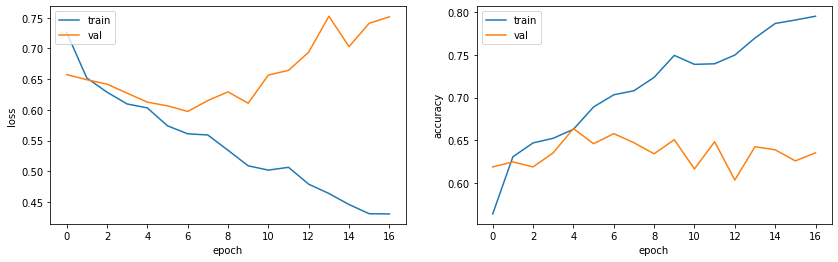

In [ ]:
graficos_entreno( ['loss', 'accuracy'], history_cnn_lstm)

Se puede observar que el modelo se comienza a overfittear bastante rápido.

#### Evaluación sobre el conjunto de test.

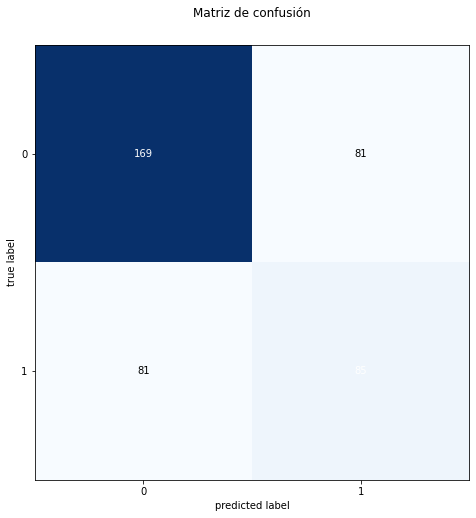

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       250
           1       0.51      0.51      0.51       166

    accuracy                           0.61       416
   macro avg       0.59      0.59      0.59       416
weighted avg       0.61      0.61      0.61       416



In [ ]:
plot_cm(X_test, Y_test, cnn_lstm)

Se observa una sutil mejora, sin embargo, no significativa en el modelo.

## Modelo 3. CNN + Stack of LSTM(subconjunto de features)

Ahora, se probará el modelo anterior con un subconjunto de las señales, especificamente las 14 señales de encefalograma(eeg).

Los features fueron guardados en el siguiente orden

In [ ]:
features = ['ecg','eda','phasic','hr','ppg','skt','ch1','ch2','ch3','ch4','ch5','ch6','ch7','ch8','ch9','ch10','ch11','ch12','ch13','ch14']

Se van a utilizar sólo las señales encefalográficas. Las que corresponden a

In [ ]:
features[6:]

['ch1',
 'ch2',
 'ch3',
 'ch4',
 'ch5',
 'ch6',
 'ch7',
 'ch8',
 'ch9',
 'ch10',
 'ch11',
 'ch12',
 'ch13',
 'ch14']

Por lo que se procede a crear el subconujnto.

In [ ]:
idx = 6
X_train_subset = X_train[:,:,idx:]
X_val_subset = X_val[:,:,idx:]
X_test_subset = X_test[:,:,idx:]

Procedemos a reiniciar el modelo de CNN+LSTM y utilizarlo sobre este subconjunto de datos.

In [ ]:
K.clear_session()

n_timesteps, n_features = X_train_subset.shape[1], X_train_subset.shape[2] #Dimensiones (51,14)
input_shape = (n_timesteps, n_features)
drop_out = 0.5

#Creamos el modelo
cnn_lstm_v2 = Sequential([
                          Input(shape=input_shape),

                          Conv1D(filters=64, kernel_size=5, strides=1, activation='relu', padding='same'),
                          MaxPooling1D(pool_size=2),

                          CuDNNLSTM(64, return_sequences=True),
                          BatchNormalization(),

                          CuDNNLSTM(64),
                          BatchNormalization(),     
                          
                          Dense(128, activation='relu'),
                          Dropout(drop_out),
                          Dense(1, activation='sigmoid')     
])
#cnn_lstm_v2.summary()

In [ ]:
cnn_lstm_v2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)
history_cnn_lstm_subset = cnn_lstm_v2.fit(X_train_subset, Y_train, epochs=100, batch_size=64, validation_data=(X_val_subset,Y_val), callbacks=[early_stopping])

Epoch 1/100
46/46 [==============================] - 4s 33ms/step - loss: 0.7146 - accuracy: 0.5796 - val_loss: 0.6664 - val_accuracy: 0.6327
Epoch 2/100
46/46 [==============================] - 1s 23ms/step - loss: 0.6764 - accuracy: 0.5960 - val_loss: 0.6568 - val_accuracy: 0.6386
Epoch 3/100
46/46 [==============================] - 1s 23ms/step - loss: 0.6519 - accuracy: 0.6147 - val_loss: 0.6476 - val_accuracy: 0.6339
Epoch 4/100
46/46 [==============================] - 1s 22ms/step - loss: 0.6273 - accuracy: 0.6351 - val_loss: 0.6383 - val_accuracy: 0.6339
Epoch 5/100
46/46 [==============================] - 1s 21ms/step - loss: 0.6033 - accuracy: 0.6647 - val_loss: 0.6255 - val_accuracy: 0.6469
Epoch 6/100
46/46 [==============================] - 1s 22ms/step - loss: 0.6095 - accuracy: 0.6600 - val_loss: 0.6314 - val_accuracy: 0.6280
Epoch 7/100
46/46 [==============================] - 1s 23ms/step - loss: 0.5869 - accuracy: 0.6777 - val_loss: 0.6199 - val_accuracy: 0.6434
Epoch 

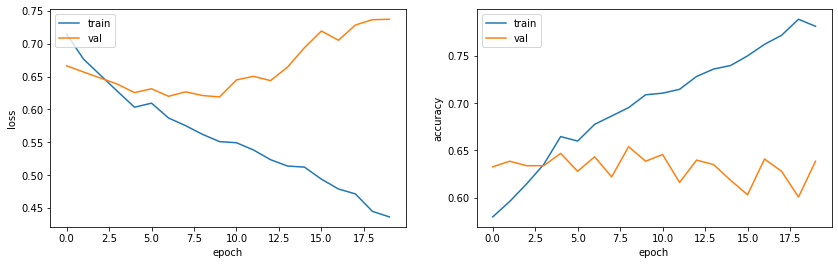

In [ ]:
graficos_entreno( ['loss', 'accuracy'], history_cnn_lstm_subset)

#### Evaluación sobre el conjunto de test.

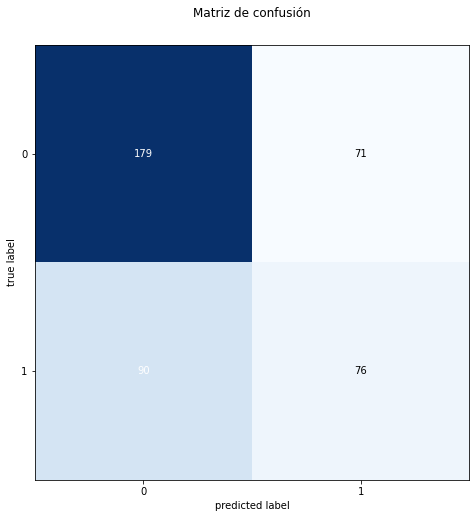

              precision    recall  f1-score   support

           0       0.67      0.72      0.69       250
           1       0.52      0.46      0.49       166

    accuracy                           0.61       416
   macro avg       0.59      0.59      0.59       416
weighted avg       0.61      0.61      0.61       416



In [ ]:
plot_cm(X_test_subset, Y_test, cnn_lstm_v2)

## Modelo 4. CNN + Stack of LSTM(subconjunto de features) con menor learning rate

Para esta ocasión se utilizará el Modelo 3, con un learning rate más bajo y se agregará más neuronas en la última capa densa.

In [ ]:
K.clear_session()

n_timesteps, n_features = X_train_subset.shape[1], X_train_subset.shape[2] #Dimensiones (51,14)
input_shape = (n_timesteps, n_features)
drop_out = 0.5

#Creamos el modelo
cnn_lstm_v3 = Sequential([
                          Input(shape=input_shape),

                          Conv1D(filters=64, kernel_size=5, strides=1, activation='relu', padding='same'),
                          MaxPooling1D(pool_size=2),

                          CuDNNLSTM(64, return_sequences=True),
                          BatchNormalization(),

                          CuDNNLSTM(64),
                          BatchNormalization(),     
                          
                          Dense(256, activation='relu'), #Pasamos de 128 a 256
                          Dropout(drop_out),
                          Dense(1, activation='sigmoid')     
])
#cnn_lstm_v3.summary()

In [ ]:
adam = keras.optimizers.Adam(lr=0.00001) #Se disminuye el learning rate
cnn_lstm_v3.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)
history_cnn_lstm_subset_v2 = cnn_lstm_v3.fit(X_train_subset, Y_train, epochs=100, batch_size=64, validation_data=(X_val_subset,Y_val), callbacks=[early_stopping])

Epoch 1/100
46/46 [==============================] - 4s 31ms/step - loss: 0.7844 - accuracy: 0.5034 - val_loss: 0.6910 - val_accuracy: 0.5249
Epoch 2/100
46/46 [==============================] - 1s 23ms/step - loss: 0.7802 - accuracy: 0.5092 - val_loss: 0.6894 - val_accuracy: 0.5273
Epoch 3/100
46/46 [==============================] - 1s 23ms/step - loss: 0.7500 - accuracy: 0.5218 - val_loss: 0.6868 - val_accuracy: 0.5379
Epoch 4/100
46/46 [==============================] - 1s 22ms/step - loss: 0.7503 - accuracy: 0.5180 - val_loss: 0.6831 - val_accuracy: 0.5557
Epoch 5/100
46/46 [==============================] - 1s 22ms/step - loss: 0.7356 - accuracy: 0.5374 - val_loss: 0.6785 - val_accuracy: 0.5711
Epoch 6/100
46/46 [==============================] - 1s 23ms/step - loss: 0.7368 - accuracy: 0.5259 - val_loss: 0.6734 - val_accuracy: 0.5770
Epoch 7/100
46/46 [==============================] - 1s 22ms/step - loss: 0.7254 - accuracy: 0.5582 - val_loss: 0.6687 - val_accuracy: 0.5841
Epoch 

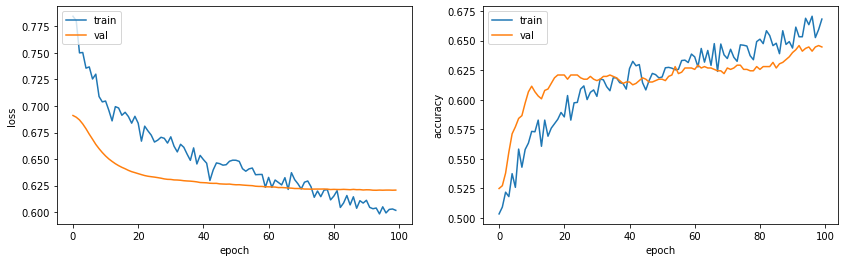

In [ ]:
graficos_entreno( ['loss', 'accuracy'], history_cnn_lstm_subset_v2)

#### Evaluación sobre el conjunto de test.

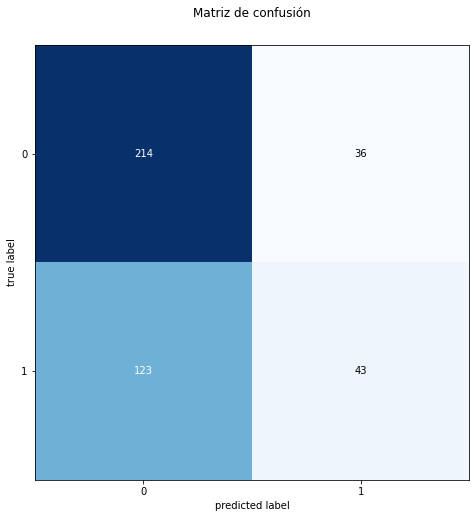

              precision    recall  f1-score   support

           0       0.64      0.86      0.73       250
           1       0.54      0.26      0.35       166

    accuracy                           0.62       416
   macro avg       0.59      0.56      0.54       416
weighted avg       0.60      0.62      0.58       416



In [ ]:
plot_cm(X_test_subset, Y_test, cnn_lstm_v3)

## Modelo 5. CNN + Stack of LSTM bidireccionales (subconjunto de features)

In [ ]:
from keras.layers import Bidirectional

In [ ]:
K.clear_session()

n_timesteps, n_features = X_train_subset.shape[1], X_train_subset.shape[2] #Dimensiones (51,14)
input_shape = (n_timesteps, n_features)
drop_out = 0.5

#Creamos el modelo
cnn_lstm_v4 = Sequential([
                          Input(shape=input_shape),

                          Conv1D(filters=64, kernel_size=5, strides=1, activation='relu', padding='same'),
                          MaxPooling1D(pool_size=2),

                          Bidirectional(
                              CuDNNLSTM(64, return_sequences=True)
                              ),
                          BatchNormalization(),

                          Bidirectional(
                              CuDNNLSTM(64)
                              ),
                          BatchNormalization(),     
                          
                          Dense(256, activation='relu'), #Pasamos de 128 a 256
                          Dropout(drop_out),
                          Dense(1, activation='sigmoid')     
])
#cnn_lstm_v4.summary()

In [ ]:
adam = keras.optimizers.Adam(lr=0.0001) #Se disminuye el learning rate
cnn_lstm_v4.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)
history_cnn_lstm_subset_v3 = cnn_lstm_v4.fit(X_train_subset, Y_train, epochs=100, batch_size=64, validation_data=(X_val_subset,Y_val), callbacks=[early_stopping])

Epoch 1/100
46/46 [==============================] - 10s 74ms/step - loss: 0.8077 - accuracy: 0.5912 - val_loss: 0.6817 - val_accuracy: 0.5569
Epoch 2/100
46/46 [==============================] - 2s 42ms/step - loss: 0.7013 - accuracy: 0.5980 - val_loss: 0.6806 - val_accuracy: 0.5474
Epoch 3/100
46/46 [==============================] - 2s 43ms/step - loss: 0.6721 - accuracy: 0.6093 - val_loss: 0.6726 - val_accuracy: 0.5924
Epoch 4/100
46/46 [==============================] - 2s 42ms/step - loss: 0.6551 - accuracy: 0.6283 - val_loss: 0.6655 - val_accuracy: 0.5877
Epoch 5/100
46/46 [==============================] - 2s 39ms/step - loss: 0.6563 - accuracy: 0.6242 - val_loss: 0.6580 - val_accuracy: 0.6055
Epoch 6/100
46/46 [==============================] - 2s 39ms/step - loss: 0.6304 - accuracy: 0.6409 - val_loss: 0.6485 - val_accuracy: 0.6161
Epoch 7/100
46/46 [==============================] - 2s 40ms/step - loss: 0.6173 - accuracy: 0.6532 - val_loss: 0.6411 - val_accuracy: 0.6244
Epoch

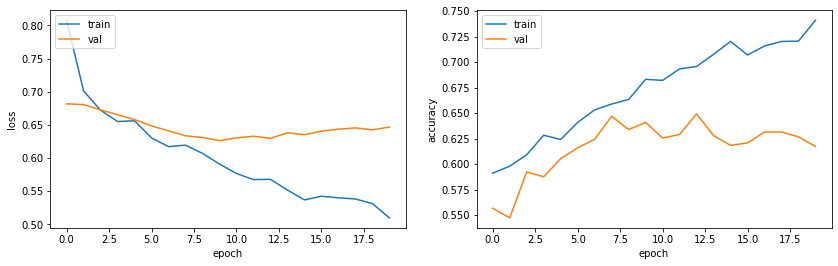

In [ ]:
graficos_entreno( ['loss', 'accuracy'], history_cnn_lstm_subset_v3)

#### Evaluación sobre el conjunto de test.

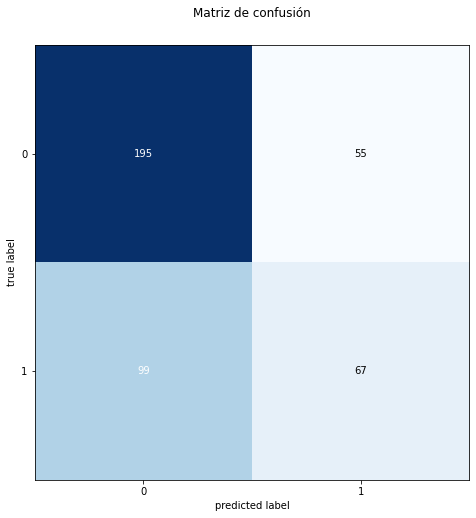

              precision    recall  f1-score   support

           0       0.66      0.78      0.72       250
           1       0.55      0.40      0.47       166

    accuracy                           0.63       416
   macro avg       0.61      0.59      0.59       416
weighted avg       0.62      0.63      0.62       416



In [ ]:
plot_cm(X_test_subset, Y_test, cnn_lstm_v4)

## Conclusiones

A modo de resumen, se probó una gran variedad de modelos de 2 clases. Más especificamente el primer modelo añadió solo una capa LSTM y obtuvo una val_accuracy 0.645. El segundo utilizó 2 capas LSTM, una capa convolucional de 32 filtros con max pooling y se obtuvo un 0.635 de val_acurracy. El tercer modelo probo el segundo modelo añadiendole un subconjunto de las señales, correspondientes a las 14 señales de encefalograma y obtuvo un val_acurracy de 0.638. El cuarto modelo construyo sobre el tercero, con un learning rate más bajo y más neuronas en la capa densa, obteniendo un val_acurracy de 0.644. Por último el quinto modelo tomó todo lo anterior, pero cambiando la LSTM por una del tipo bidireccional, esta vez obteniendo apenas un val_acurracy de 0.617. 

Según lo anterior, se concluye no haber obtenido resultados favorables (aquellos sobre 80% accuracy/val_accuracy) que pudieran permitir demostrar efectividad y aprendizaje real. Se probó con subconjuntos de features, cambiando hiperparámetros, agregando capas densas, agregando LSTM en serie y sin embargo no pariecese haber surtido mucho efecto.

Como propuesta de mejora se plantea la posibilidad de haber utilizado mejores arquitecturas a las exploradas en el curso, potencialmente habiendose tratado con información de una dificultad de procesamiento que se escapa de alcance de los modelos en cuestión.

<center>
    <h1>
        🎅🎁 ¡Felices fiestas de fin de año! 🎅🎁
    </h1>
</center>